In [0]:
import org.apache.spark
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from collections import defaultdict
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Imputer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
order_sparkDF = spark.read.csv("/FileStore/tables/orders.csv", header="true", inferSchema="true")
orders_df = order_sparkDF.toPandas()
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [0]:
order_products_prior_sparkDF = spark.read.csv("/FileStore/tables/order_products__prior.csv", header="true", inferSchema="true")
order_products_prior_df = order_products_prior_sparkDF.toPandas()
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [0]:
urlA = 'https://drive.google.com/file/d/1W8bNivEj7H0WXqZx1X83fQEYz4A3XadY/view?usp=sharing'
urlA2 = 'https://drive.google.com/uc?id=' + urlA.split('/')[-2]
aisles_df = pd.read_csv(urlA2)
aisles_df

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [0]:
urlD = 'https://drive.google.com/file/d/1unatDL4jGx5CCHYN2Q9YnDjnq43AgtJp/view?usp=sharing'
urlD2 = 'https://drive.google.com/uc?id=' + urlD.split('/')[-2]
departments_df = pd.read_csv(urlD2)
departments_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [0]:
urlOPT = 'https://drive.google.com/file/d/1IyZbHlrD8zXB8zhgx2XKxt812THThGRu/view?usp=sharing'
urlOPT2 = 'https://drive.google.com/uc?id=' + urlOPT.split('/')[-2]
order_products_train = pd.read_csv(urlOPT2)
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [0]:
urlP = 'https://drive.google.com/file/d/1Gkwkg56XgLzX_hyZDjEyHyRbcSjuWKp3/view?usp=sharing'
urlP2 = 'https://drive.google.com/uc?id=' + urlP.split('/')[-2]
products = pd.read_csv(urlP2)
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [0]:
#merging the data together
temp = pd.merge(order_products_prior_df, products, on=["product_id"])
temp = pd.merge(temp, orders_df, on=["order_id"])
temp = pd.merge(temp, aisles_df, on=["aisle_id"])
data = pd.merge(temp, departments_df, on=["department_id"])
del temp
data

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3243156,20731,1,0,Straight Sherry,134,5,166400,prior,3,1,13,12.0,specialty wines champagnes,alcohol
32434485,860862,30582,1,0,Natural Champagne,134,5,104017,prior,13,5,14,18.0,specialty wines champagnes,alcohol
32434486,1333472,27906,1,0,Imperial Champagne,134,5,62079,prior,10,3,10,10.0,specialty wines champagnes,alcohol
32434487,2122701,26086,1,1,La Grand Dame Brut Champagne,134,5,77799,prior,2,3,14,3.0,specialty wines champagnes,alcohol


In [0]:
# data1 = data.sample(frac =.01)

In [0]:
#converting to spark dataframe
sparkDF = spark.createDataFrame(data)

In [0]:
# from pyspark.sql.functions import col, explode, array, lit
# major_df = sparkDF.filter(col("reordered") == 1)
# minor_df = sparkDF.filter(col("reordered") == 0)
# ratio = int(major_df.count()/minor_df.count())
# print("ratio: {}".format(ratio))

In [0]:
# sampled_majority_df = major_df.sample(False, 1/ratio)
# sparkDF = sampled_majority_df.unionAll(minor_df)
# sparkDF.show()

In [0]:
# a = range(ratio)
# # duplicate the minority rows
# oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# # combine both oversampled minority rows and previous majority rows 
# sparkDF = major_df.unionAll(oversampled_df)
# sparkDF.show()

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   product_id              int32  
 2   add_to_cart_order       int32  
 3   reordered               int32  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   user_id                 int32  
 8   eval_set                object 
 9   order_number            int32  
 10  order_dow               int32  
 11  order_hour_of_day       int32  
 12  days_since_prior_order  float64
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int32(8), int64(2), object(4)
memory usage: 2.9+ GB


In [0]:
data_types = defaultdict(list)
for entry in sparkDF.schema.fields:
   data_types[str(entry.dataType)].append(entry.name)

In [0]:
#filling missing values
strings_used = [var for var in data_types["StringType"]]

missing_data_fill = {}
for var in strings_used:
   missing_data_fill[var] = "missing"

sparkDF = sparkDF.fillna(missing_data_fill)

In [0]:
sparkDF.drop('eval_set')

Out[17]: DataFrame[order_id: int, product_id: int, add_to_cart_order: int, reordered: int, product_name: string, aisle_id: bigint, department_id: bigint, user_id: int, order_number: int, order_dow: int, order_hour_of_day: int, days_since_prior_order: double, aisle: string, department: string]

In [0]:
sparkDF.drop('eval_set_string_encoded')

Out[18]: DataFrame[order_id: int, product_id: int, add_to_cart_order: int, reordered: int, product_name: string, aisle_id: bigint, department_id: bigint, user_id: int, eval_set: string, order_number: int, order_dow: int, order_hour_of_day: int, days_since_prior_order: double, aisle: string, department: string]

In [0]:
strings_used.remove('eval_set')

In [0]:
#encoding and indexing dataset
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
sparkDF = ppl.fit(sparkDF).transform(sparkDF)

In [0]:
sparkDF.show()

+--------+----------+-----------------+---------+--------------------+--------+-------------+-------+--------+------------+---------+-----------------+----------------------+-----+----------+---------------------------+--------------------+-------------------------+--------------------+----------------+------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|aisle|department|product_name_string_encoded|aisle_string_encoded|department_string_encoded|product_name_one_hot|   aisle_one_hot|department_one_hot|
+--------+----------+-----------------+---------+--------------------+--------+-------------+-------+--------+------------+---------+-----------------+----------------------+-----+----------+---------------------------+--------------------+-------------------------+--------------------+----------------+------------------+
|       2|     33120|       

In [0]:
for c in data_types["LongType"]:
  sparkDF = sparkDF.withColumn(c+ "_cast_to_double", sparkDF[c].cast("double"))

cast_vars = [var for var in  sparkDF.columns if var.endswith("_cast_to_double")]
cast_vars_imputed  = [var+ "imputed" for var in cast_vars]

imputer_for_cast_vars = Imputer(inputCols = cast_vars, outputCols = cast_vars_imputed)
sparkDF = imputer_for_cast_vars.fit(sparkDF).transform(sparkDF)

In [0]:
features = cast_vars_imputed + [var + "_one_hot" for var in strings_used]

vector_assembler = VectorAssembler(inputCols = features, outputCol= "features")
data_training_and_test = vector_assembler.transform(sparkDF)

In [0]:
#scaling dataset
scale = StandardScaler(inputCol='features', outputCol='standardized')
data_scale=scale.fit(data_training_and_test)
data_training_and_test =data_scale.transform(data_training_and_test)

In [0]:
# from pyspark.ml.feature import PCA
# pca_model = PCA(k = 6, inputCol = "features", outputCol = "pca_features")

In [0]:
# model = pca_model.fit(data_training_and_test)
# data_training_and_test = model.transform(data_training_and_test)

Out[27]: <AxesSubplot:xlabel='reordered', ylabel='count'>

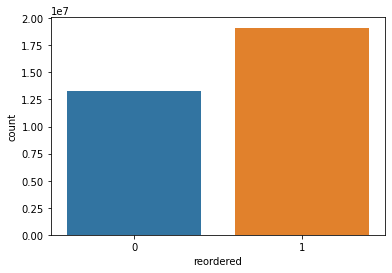

In [0]:
sns.countplot(x=data['reordered'])

In [0]:
#splitting data into training and testing
(training_data, test_data) = data_training_and_test.randomSplit([0.7, 0.3])

In [0]:
#training logistic regression model
lr = LogisticRegression(labelCol="reordered", featuresCol = 'features', maxIter=10)
lrModel = lr.fit(training_data)

In [0]:
#getting predictions
lrpredictions = lrModel.transform(test_data)

In [0]:
#gettin accuracy
evaluator= BinaryClassificationEvaluator(labelCol = "reordered", rawPredictionCol="probability", metricName= "areaUnderROC")
accuracy = evaluator.evaluate(lrpredictions)

In [0]:
print("Accuracy of logistic regression model is: ", accuracy)

Accuracy of logistic regression model is:  0.6692412226857567


In [0]:
print('Below table shows the prediction and probability whether the order will be reordered.')
lrpredictions.select('order_id', 'reordered', 'prediction', 'rawPrediction', 'probability').limit(10).toPandas()

Below table shows the prediction and probability whether the order will be reordered.
/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field rawPrediction. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,order_id,reordered,prediction,rawPrediction,probability
0,2,1,1.0,"[-0.8901820229062557, 0.8901820229062557]","[0.2910722657241014, 0.7089277342758986]"
1,3,1,1.0,"[-0.27357181653923024, 0.27357181653923024]","[0.4320304303005824, 0.5679695696994176]"
2,5,1,1.0,"[-0.2649134537820823, 0.2649134537820823]","[0.4341562583254993, 0.5658437416745007]"
3,13,0,0.0,"[0.40902708407822586, -0.40902708407822586]","[0.6008545689338733, 0.39914543106612665]"
4,22,1,1.0,"[-0.4383667819939765, 0.4383667819939765]","[0.39213020114479435, 0.6078697988552056]"
5,25,1,1.0,"[-0.6466470222771324, 0.6466470222771324]","[0.34374552047451357, 0.6562544795254864]"
6,26,0,1.0,"[-1.1485165123721166, 1.1485165123721166]","[0.24076015243157403, 0.759239847568426]"
7,30,0,1.0,"[-1.0456011406386598, 1.0456011406386598]","[0.2600706967914827, 0.7399293032085172]"
8,33,0,1.0,"[-0.47692656592686583, 0.47692656592686583]","[0.38297813409583403, 0.617021865904166]"
9,43,0,1.0,"[-0.5190707868251789, 0.5190707868251789]","[0.3730695404636872, 0.6269304595363128]"


In [0]:
#training the naive bayes model
nb = NaiveBayes(labelCol="reordered", featuresCol = 'features')
nbModel = nb.fit(training_data)

In [0]:
#getting predictions
nbpredictions = nbModel.transform(test_data)

In [0]:
#getting accuracy
evaluator= BinaryClassificationEvaluator(labelCol = "reordered", rawPredictionCol="probability", metricName= "areaUnderROC")
accuracy = evaluator.evaluate(nbpredictions)

In [0]:
print("Accuracy of naive bayes model is: ", accuracy)

In [0]:
print('Below table shows the prediction and probability whether the order will be reordered.')
nbpredictions.select('order_id', 'reordered', 'prediction', 'rawPrediction', 'probability').limit(10).toPandas()

In [0]:
# #training decision tree classifier
# dt = DecisionTreeClassifier(labelCol="reordered", featuresCol = 'features')
# dtModel = dt.fit(training_data)

In [0]:
# #getting predictions
# dtpredictions = dtModel.transform(test_data)

In [0]:
# #getting accuracy
# evaluator= BinaryClassificationEvaluator(labelCol = "reordered", rawPredictionCol="probability", metricName= "areaUnderROC")
# accuracy = evaluator.evaluate(dtpredictions)

In [0]:
# print("Accuracy of decision tree classifier is: ", accuracy)

In [0]:
# print('Below table shows the prediction and probability whether the order will be reordered.')
# dtpredictions.select('order_id', 'reordered', 'prediction', 'rawPrediction', 'probability').limit(10).toPandas()

In [0]:
# #training random forest classifier
# rf = RandomForestClassifier(labelCol="reordered", featuresCol = 'features')
# rfModel = rf.fit(training_data)

In [0]:
# #getting predictions
# rfpredictions = rfModel.transform(test_data)

In [0]:
# #getting accuracy
# evaluator= BinaryClassificationEvaluator(labelCol = "reordered", rawPredictionCol="probability", metricName= "areaUnderROC")
# accuracy = evaluator.evaluate(rfpredictions)

In [0]:
# print("Accuracy of random forest classifier is: ", accuracy)

In [0]:
# print('Below table shows the prediction and probability whether the order will be reordered.')
# rfpredictions.select('order_id', 'reordered', 'prediction', 'rawPrediction', 'probability').limit(10).toPandas()